In [2]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farhanpravej","key":"1589ce359021a464593c7d708bfcb682"}'}

In [3]:
!pip install -q kaggle


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d vatsalmavani/spotify-dataset
!unzip spotify-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/vatsalmavani/spotify-dataset
License(s): unknown
  0% 0.00/16.5M [00:00<?, ?B/s]
100% 16.5M/16.5M [00:00<00:00, 438MB/s]
Archive:  spotify-dataset.zip
  inflating: data/data.csv           
  inflating: data/data_by_artist.csv  
  inflating: data/data_by_genres.csv  
  inflating: data/data_by_year.csv   
  inflating: data/data_w_genres.csv  


In [5]:
import pandas as pd


df = pd.read_csv("data/data_w_genres.csv")
df = df.dropna(subset=["valence", "energy"])

# Keep mood-relevant columns
mood_df = df[["genres", "artists", "valence", "energy"]].copy()


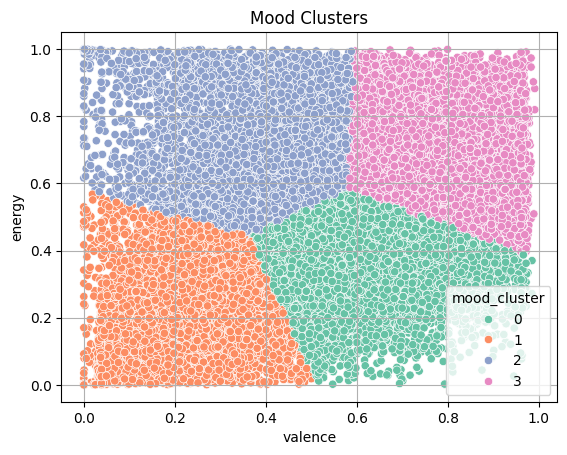

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
scaled = scaler.fit_transform(mood_df[["valence", "energy"]])

# Cluster into 4 moods
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
mood_df["mood_cluster"] = kmeans.fit_predict(scaled)

# Optional: visualize
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=mood_df, x="valence", y="energy", hue="mood_cluster", palette="Set2")
plt.title("Mood Clusters")
plt.grid(True)
plt.show()


In [7]:
mood_map = {
    0: "Chill",
    1: "Energetic",
    2: "Happy",
    3: "Sad"
}

mood_df["mood"] = mood_df["mood_cluster"].map(mood_map)
mood_df.to_csv("data/mood_labeled_tracks.csv", index=False)


In [8]:
def recommend_songs(mood, top_n=10, genre_filter=None, include_links=True):
    mood = mood.capitalize()
    df = pd.read_csv("data/mood_labeled_tracks.csv")

    if genre_filter:
        mask = df['genres'].str.contains(genre_filter, case=False, na=False)
        filtered_df = df[(df['mood'] == mood) & mask]
    else:
        filtered_df = df[df['mood'] == mood]

    if filtered_df.empty:
        return f"😢 No songs found for mood '{mood}' with genre '{genre_filter}'."

    recommendations = filtered_df.sample(n=min(top_n, len(filtered_df)))

    if include_links:
        def make_link(row):
            query = f"{row['genres']} {row['artists']}".replace(" ", "+")
            return f"https://open.spotify.com/search/{query}"
        recommendations["spotify_search"] = recommendations.apply(make_link, axis=1)

    return recommendations[["artists", "genres", "mood", "spotify_search"]] if include_links else recommendations[["artists", "genres", "mood"]]


In [9]:
!pip install -q transformers


In [10]:
from transformers import pipeline

emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base"
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [11]:
def map_emotion_to_mood(emotion_label):
    if emotion_label in ["joy", "surprise"]:
        return "Happy"
    elif emotion_label in ["sadness", "fear"]:
        return "Sad"
    elif emotion_label in ["anger", "disgust"]:
        return "Energetic"
    elif emotion_label == "neutral":
        return "Chill"
    else:
        return "Chill"


In [12]:
def detect_mood_from_text(user_input):
    result = emotion_classifier(user_input)
    emotion = result[0]['label']
    mood = map_emotion_to_mood(emotion)
    print(f"🧠 Detected Emotion: {emotion} → 🎧 Mood: {mood}")
    return mood


In [13]:
user_text = input("How are you feeling today?\n> ")
mood = detect_mood_from_text(user_text)
recommend_songs(mood, top_n=5)


How are you feeling today?
> angry
🧠 Detected Emotion: anger → 🎧 Mood: Energetic


,artists,genres,mood,spotify_search
10298,Herbert Henck,"['avant-garde', 'compositional ambient', 'cont...",Energetic,https://open.spotify.com/search/['avant-garde'...
8623,Frode Fjellheim,['yoik'],Energetic,https://open.spotify.com/search/['yoik']+Frode...
27736,Xumantra,"['healing', 'meditation', 'tone']",Energetic,"https://open.spotify.com/search/['healing',+'m..."
12363,Johnnie Johnston,[],Energetic,https://open.spotify.com/search/[]+Johnnie+Joh...
6463,Dmytro Popov,[],Energetic,https://open.spotify.com/search/[]+Dmytro+Popov


In [14]:
!pip install -q deepface opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.9 MB/s eta 0:00:00


In [15]:
import cv2
from deepface import DeepFace
from IPython.display import Image, display


25-06-19 02:30:31 - Directory /root/.deepface has been created
25-06-19 02:30:31 - Directory /root/.deepface/weights has been created


Saving WIN_20231109_12_12_05_Pro.jpg to WIN_20231109_12_12_05_Pro.jpg


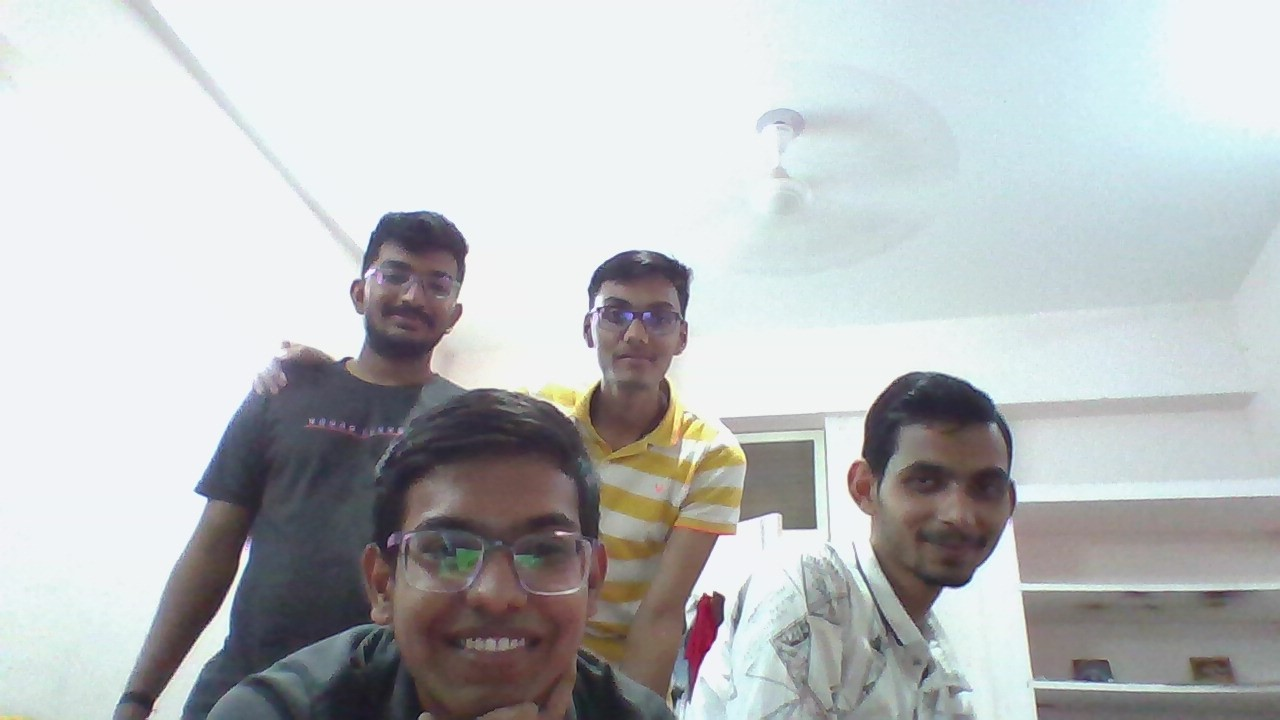

In [16]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    display(Image(filename))


In [17]:
def detect_mood_from_image(img_path):
    try:
        analysis = DeepFace.analyze(img_path=img_path, actions=['emotion'], enforce_detection=True)
        emotion = analysis[0]['dominant_emotion']
        print(f"🧠 Detected Facial Emotion: {emotion}")

        # Map to music mood
        mood = map_emotion_to_mood(emotion)
        print(f"🎧 Music Mood: {mood}")
        return mood
    except Exception as e:
        print("😢 Error detecting face. Try another image.")
        print(str(e))
        return None


In [18]:
mood = detect_mood_from_image(img_path)
if mood:
    recommend_songs(mood, top_n=5)


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5


25-06-19 02:32:01 - facial_expression_model_weights.h5 will be downloaded...


100%|██████████| 5.98M/5.98M [00:00<00:00, 200MB/s]


🧠 Detected Facial Emotion: neutral
🎧 Music Mood: Chill
